paper link: https://arxiv.org/pdf/2103.04874.pdf

In this paper, they have attempted to show how SVD-based methods perform against NN-based methods for dimension reduction tasks. They hired PCA and ISOMAP as SVD-based methods and used vanilla auto-encoder and variational auto-encoder for NN-based ones. Two SVD-based methods and two auto-encoders were applied to reduce the dimension of each dataset and a k-NN classifier was trained on each projection (the k parameter is determined by random search method). This work brings an insight on how much auto-encoders trade computation time off for projection’s quality as evaluated by the accuracy of a k-NN classifier.

The paper has used three datasets: MNIST, Fashion MNIST and Cifar10 for comparison, but in this implementation, only Fashion MNIST is used. The paper also considered several values (ranging from 0 to 10% of the original dimensions) for the latent space, but the implementation considered only two values (1% and 5%).

The paper benefit from early stopping method to finish the training, but due to the goal of this implementation and the lack of resources, we only trained the models for ten epochs. We also trained two models for 50 epochs to check the positive effect of increasing the number of epochs.

importing libraries and reading the dataset

In [ ]:
import torchvision
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import ticker
from torch.utils.data import DataLoader
from sklearn.manifold import Isomap
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Define the transformation to apply to the dataset
transform = torchvision.transforms.transforms.Compose([
    torchvision.transforms.transforms.ToTensor(),
])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

X_train = torch.stack([X for X,_ in trainset])
y_train = [label for _,label in trainset]
X_test = torch.stack([X for X,_ in testset])
y_test = [label for _,label in testset]

100%|██████████| 26421880/26421880 [00:03<00:00, 8203836.11it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 141477.60it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2642306.31it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6476387.82it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# Dataset analysis

Data distribution of train and test set (The data are perfectly balanced)

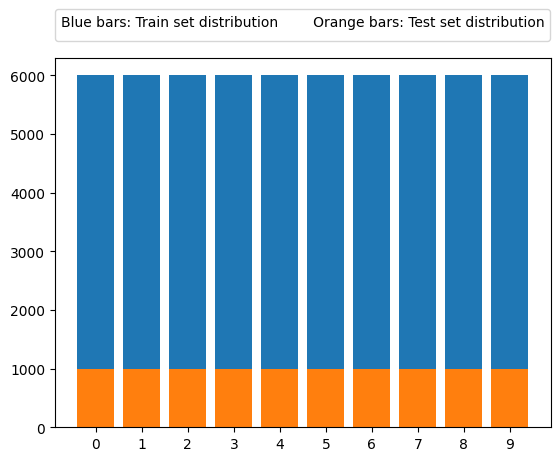

In [ ]:
labels , freqs = np.unique(y_train, return_counts=True)
plt.xticks(range(min(labels), max(labels)+1, 1))
bars_train = plt.bar(labels, freqs)

labels , freqs = np.unique(y_test, return_counts=True)
#plt.xticks(range(min(labels), max(labels)+1, 1))
bars_test = plt.bar(labels, freqs)

legend_labels = 'Blue bars: Train set distribution        Orange bars: Test set distribution'
plt.legend(title = legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(legend_labels))

The dimensions of each data in the dataset

In [ ]:
print('dimension of each data: ', X_train[0].shape)

dimension of each data:  torch.Size([1, 28, 28])


Sample of the dataset (The data are normalized)

In [ ]:
X_train[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

First 10 row of train set (The dataset is shuffled)

In [ ]:
print('first 10 data labels in train set: ', y_train[0:10])

first 10 data labels in train set:  [9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


# Random search for KNN's k parameter

In [ ]:
def knn_param_random_search(X_train, y_train, X_test, y_test):
  pipeline = Pipeline([
      ('knn', KNeighborsClassifier())
  ])
  knn_params = [int(i) for i in (np.arange(1,int((len(X_train) ** 0.5)), (len(X_train) ** 0.5)/60))] ##gofte maghale
  parameters = {
    'knn__n_neighbors': knn_params
  }

  random_search = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy')#default steps_number = 10
  random_search.fit(X_train, y_train)

  best_performance = random_search.best_score_

  print("Best Number of Components:", random_search.best_params_)
  print("Best Performance:", random_search.best_score_)

  best_estimator = random_search.best_estimator_
  knn = best_estimator.named_steps['knn']
  knn_X_test_result = knn.predict(X_test)
  print("Accuracy for test set: ", accuracy_score(y_test, knn_X_test_result))

# PCA

In [ ]:
flatten_X_train = X_train.reshape(len(X_train), X_train.shape[-1] * X_train.shape[-2]) #(60000, 784)
flatten_X_test = X_test.reshape(len(X_test), X_test.shape[-1] * X_test.shape[-2]) #(10000, 784)

pca_1_percent = PCA(n_components=7) #1% of original dimensions
train_set_after_pca_1_percent = pca_1_percent.fit_transform(flatten_X_train)
test_set_after_pca_1_percent = pca_1_percent.transform(flatten_X_test)

pca_5_percent = PCA(n_components=40) #5% of original dimensions
train_set_after_pca_5_percent = pca_5_percent.fit_transform(flatten_X_train)
test_set_after_pca_5_percent = pca_5_percent.transform(flatten_X_test)

print("Result: \n")
print("Latent space = 1% of original dimensions")
knn_param_random_search(train_set_after_pca_1_percent, y_train,
                        test_set_after_pca_1_percent, y_test)
print("\nLatent space = 5% of original dimensions")
knn_param_random_search(train_set_after_pca_5_percent, y_train,
                        test_set_after_pca_5_percent, y_test)

Result: 

Latent space = 1% of original dimensions
Best Number of Components: {'knn__n_neighbors': 33}
Best Performance: 0.7864166666666665
Accuracy for test set:  0.776

Latent space = 5% of original dimensions
Best Number of Components: {'knn__n_neighbors': 49}
Best Performance: 0.8422166666666666
Accuracy for test set:  0.8399


now let’s see what happens if we apply random search on PCA parameter (n_components) too.

In [ ]:
#dataset dimensions = 28 * 28 = 784
#flatten_X_train = X_train.reshape(60000, 784)
pipeline = Pipeline([
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])
components_number_ceil = np.ceil(0.055 * 784)
components_number_floor = 0.03 * 784
dimensions_reduction_params = np.arange(int(components_number_floor), int(components_number_ceil))
knn_params = [int(i) for i in (np.arange(1,int((len(X_train) ** 0.5)), (len(X_train) ** 0.5)/60))] ##gofte maghale
parameters = {
  'pca__n_components': dimensions_reduction_params,
  'knn__n_neighbors': knn_params
}

random_search = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='accuracy')#default steps number = 10
random_search.fit(flatten_X_train, y_train)
best_performance = random_search.best_score_

print("Best Number of Components:", random_search.best_params_)
print("Best Performance:", random_search.best_score_)

flatten_X_test = X_test.reshape(10000, 784)
best_estimator = random_search.best_estimator_
pca = best_estimator.named_steps['pca']
knn = best_estimator.named_steps['knn']
X_test_after_pca = pca.transform(flatten_X_test)
knn_X_test_result = knn.predict(X_test_after_pca)
print("Accuracy for test set: ", accuracy_score(y_test, knn_X_test_result))

Best Number of Components: {'pca__n_components': 23, 'knn__n_neighbors': 17}
Best Performance: 0.8474999999999999
Accuracy for test set:  0.8472


Little visualization: Explained Variation by PCA
 - green line: Cumulative chart
 - blue bars: Explanation per component

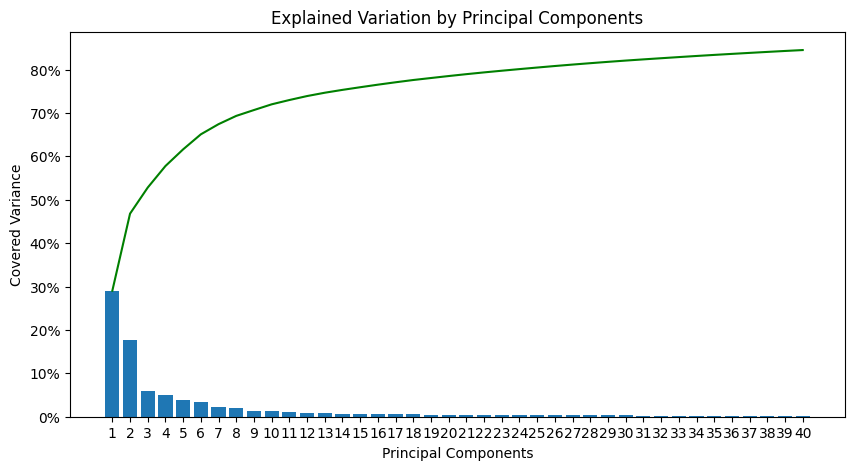

In [ ]:
x_range = np.array(range(1, 40+1))
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.plot(x_range, pca_5_percent.explained_variance_ratio_.cumsum(), color='green')
ax.bar(x_range, pca_5_percent.explained_variance_ratio_)
ax.set_xlabel('Principal Components')
ax.set_ylabel('Covered Variance')
ax.set_title('Explained Variation by Principal Components')
ax.set_xticks(np.arange(1, 40+1), [str(i) for i in range(1, 40+1)])
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

# ISOMAP

* Because of ISOMAP time complexity (n^3), we use only 10,000 samples of the dataset

In [ ]:
isomap_1_percent = Isomap(n_components=7) #1% of original dimensions
train_set_after_isomap_1_percent = isomap_1_percent.fit_transform(flatten_X_train[0:10000])
test_set_after_isomap_1_percent = isomap_1_percent.transform(flatten_X_test)

isomap_5_percent = Isomap(n_components=40) #5% of original dimensions
train_set_after_isomap_5_percent = isomap_5_percent.fit_transform(flatten_X_train[0:10000])
test_set_after_isomap_5_percent = isomap_5_percent.transform(flatten_X_test)

print("Result: \n")
print("Latent space = 1% of original dimensions")
knn_param_random_search(train_set_after_isomap_1_percent, y_train[0:10000],
                        test_set_after_isomap_1_percent, y_test)
print("\nLatent space = 5% of original dimensions")
knn_param_random_search(train_set_after_isomap_5_percent, y_train[0:10000],
                        test_set_after_isomap_5_percent, y_test)

Result: 

Latent space = 1% of original dimensions
Best Number of Components: {'knn__n_neighbors': 22}
Best Performance: 0.7666
Accuracy for test set:  0.7629

Latent space = 5% of original dimensions
Best Number of Components: {'knn__n_neighbors': 7}
Best Performance: 0.7998000000000001
Accuracy for test set:  0.7828


# Vanilia Auto-Encoder

In [ ]:
class CustomCNNAutoEncoder(torch.nn.Module):
  def __init__(self, latent_space):
    super().__init__()
    # Encoder layers
    self.encoder = torch.nn.Sequential(
      torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(16),
      torch.nn.ReLU(True),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(8),
      torch.nn.ReLU(True),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Flatten(),
      torch.nn.Linear(7*7*8, latent_space)
    )
    self.to_decoder = torch.nn.Linear(latent_space, 7*7*8)
    self.decoder = torch.nn.Sequential(
      torch.nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.BatchNorm2d(16),
      torch.nn.ReLU(True),
      torch.nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
      #torch.nn.BatchNorm2d(1)
      torch.nn.Sigmoid()
    )
    self.initialize_weights()

  def initialize_weights(self):
    for module in self.encoder.modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
    torch.nn.init.xavier_uniform_(self.to_decoder.weight)
    for module in self.decoder.modules():
      if isinstance(module, torch.nn.ConvTranspose2d) or isinstance(module, torch.nn.Linear):
          torch.nn.init.xavier_uniform_(module.weight)


  def forward(self, x, encoder_output = False):
    e = self.encoder(x)
    if encoder_output:
      return e
    d = self.to_decoder(e)
    d = d.reshape((x.shape[0],8,7,7))
    d = self.decoder(d)
    return d




class CustomLinearAutoEncoder(torch.nn.Module):
  def __init__(self, latent_space):
    super().__init__()
    primary_space = 784
    self.encoder = torch.nn.Sequential(
      torch.nn.Linear(primary_space, primary_space//2),
      torch.nn.BatchNorm1d(primary_space//2),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//2, primary_space//4),
      torch.nn.BatchNorm1d(primary_space//4),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//4, primary_space//8),
      torch.nn.BatchNorm1d(primary_space//8),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//8, primary_space//16),
      torch.nn.BatchNorm1d(primary_space//16),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//16, latent_space)
    )
    self.decoder = torch.nn.Sequential(
      torch.nn.Linear(latent_space, primary_space//16),
      torch.nn.BatchNorm1d(primary_space//16),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//16, primary_space//8),
      torch.nn.BatchNorm1d(primary_space//8),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//8, primary_space//4),
      torch.nn.BatchNorm1d(primary_space//4),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//4, primary_space//2),
      torch.nn.BatchNorm1d(primary_space//2),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//2, primary_space),
      torch.nn.Sigmoid()
    )
    self.initialize_weights()

  def initialize_weights(self):
    for module in self.encoder.modules():
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
    for module in self.decoder.modules():
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)

  def forward(self, x, encoder_output = False):
    x = x.reshape((x.shape[0], 28*28))

    e = self.encoder(x)
    if encoder_output:
      return e

    d = self.decoder(e)
    return d

model_linear_1 = CustomLinearAutoEncoder(latent_space=40).to(device) #5%
model_linear_2 = CustomLinearAutoEncoder(latent_space=7).to(device) #1%
model_CNN_1 = CustomCNNAutoEncoder(latent_space=40).to(device)
model_CNN_2 = CustomCNNAutoEncoder(latent_space=7).to(device)

In [ ]:
def train_ae(X_train, model, epochs = 10, batch_size = 100):
  train_validation_split_index = int(len(X_train) * 0.9)
  X_loader = DataLoader(X_train[:train_validation_split_index], batch_size= batch_size)
  X_val_loader = DataLoader(X_train[train_validation_split_index:], batch_size= batch_size)

  model = model.to(device)
  optimizer = torch.optim.AdamW(model.parameters())
  loss_fn = torch.nn.MSELoss()

  training_loss_history = []
  validation_loss_history = []

  for e in range(epochs):
    print('\nEpoch: ', e+1,'\n')
    print('train phase')
    model.train()
    training_loss = 0
    for inputs in tqdm(X_loader):
      inputs = inputs.to(device)
      output = model(inputs)
      inputs = inputs.reshape((batch_size, 784))
      output = output.reshape((batch_size, 784))
      loss = loss_fn(output, inputs)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      training_loss += loss.item()
    training_loss = training_loss / len(X_loader)
    print('training_loss: ', training_loss)
    training_loss_history.append(training_loss)

    print('\nvalidation phase')
    model.eval()
    validation_loss = 0
    for inputs in tqdm(X_val_loader):
      inputs = inputs.to(device)
      output = model(inputs)
      inputs = inputs.reshape((batch_size, 784))
      output = output.reshape((batch_size, 784))
      loss = loss_fn(output, inputs)
      validation_loss += loss.item()
    validation_loss = validation_loss / len(X_val_loader)
    print('validation_loss: ', validation_loss)
    validation_loss_history.append(validation_loss)
    print('________________________________________________')
  return training_loss_history, validation_loss_history


def inference_on_test(model, train_set, test_set):
  model.eval()
  with torch.no_grad():
    test_ouput = (model(test_set.to(device), True)).cpu()
    train_output = (model(train_set.to(device), True)).cpu()
  return train_output, test_ouput


def plot_loss(loss):
  x = range(len(loss[0]))
  plt.plot(x, loss[0], label='train loss')
  plt.plot(x, loss[1], label='validation loss')
  plt.legend()
  #plt.gca().set_yticklabels([])
  plt.title('Loss value over epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()



## Vanilia Auto-encoder with Linear layers and 40 layers at latent space (95% dimensions reduction)

In [ ]:
model_linear_1_loss_history = train_ae(X_train, model_linear_1)


Epoch:  1 

train phase


100%|██████████| 540/540 [00:06<00:00, 86.11it/s] 


training_loss:  0.026838594409464685

validation phase


100%|██████████| 60/60 [00:00<00:00, 205.92it/s]


validation_loss:  0.01929604047909379
________________________________________________

Epoch:  2 

train phase


100%|██████████| 540/540 [00:04<00:00, 118.39it/s]


training_loss:  0.01823810229457363

validation phase


100%|██████████| 60/60 [00:00<00:00, 333.67it/s]


validation_loss:  0.01629267996177077
________________________________________________

Epoch:  3 

train phase


100%|██████████| 540/540 [00:02<00:00, 195.18it/s]


training_loss:  0.016245628048286394

validation phase


100%|██████████| 60/60 [00:00<00:00, 431.24it/s]


validation_loss:  0.01529996182459096
________________________________________________

Epoch:  4 

train phase


100%|██████████| 540/540 [00:02<00:00, 215.24it/s]


training_loss:  0.015094278363028058

validation phase


100%|██████████| 60/60 [00:00<00:00, 464.29it/s]


validation_loss:  0.014382553069541852
________________________________________________

Epoch:  5 

train phase


100%|██████████| 540/540 [00:02<00:00, 216.25it/s]


training_loss:  0.014292443243579731

validation phase


100%|██████████| 60/60 [00:00<00:00, 477.03it/s]


validation_loss:  0.014005681158353885
________________________________________________

Epoch:  6 

train phase


100%|██████████| 540/540 [00:02<00:00, 212.61it/s]


training_loss:  0.013701382036217385

validation phase


100%|██████████| 60/60 [00:00<00:00, 346.23it/s]


validation_loss:  0.01360522002602617
________________________________________________

Epoch:  7 

train phase


100%|██████████| 540/540 [00:03<00:00, 174.19it/s]


training_loss:  0.01325733085438885

validation phase


100%|██████████| 60/60 [00:00<00:00, 452.08it/s]


validation_loss:  0.013222689786925913
________________________________________________

Epoch:  8 

train phase


100%|██████████| 540/540 [00:02<00:00, 212.98it/s]


training_loss:  0.01289878576407554

validation phase


100%|██████████| 60/60 [00:00<00:00, 462.98it/s]


validation_loss:  0.012959468861420948
________________________________________________

Epoch:  9 

train phase


100%|██████████| 540/540 [00:03<00:00, 145.06it/s]


training_loss:  0.012591419536275444

validation phase


100%|██████████| 60/60 [00:00<00:00, 440.22it/s]


validation_loss:  0.012697309736783307
________________________________________________

Epoch:  10 

train phase


100%|██████████| 540/540 [00:03<00:00, 162.57it/s]


training_loss:  0.012341096504005018

validation phase


100%|██████████| 60/60 [00:00<00:00, 119.51it/s]

validation_loss:  0.01257885000668466
________________________________________________


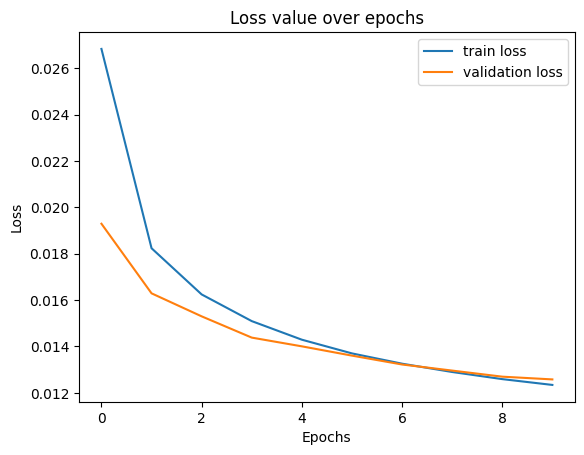

In [ ]:
plot_loss(model_linear_1_loss_history)

In [ ]:
i_train, i_test = inference_on_test(model_linear_1, X_train, X_test)
knn_param_random_search(i_train, y_train, i_test, y_test)

Best Number of Components: {'knn__n_neighbors': 21}
Best Performance: 0.8591
Accuracy for test set:  0.8533


## Vanilia Auto-encoder with Linear layers and 7 layers at latent space (99% dimensions reduction)

In [ ]:
model_linear_2_loss_history = train_ae(X_train, model_linear_2)


Epoch:  1 

train phase


100%|██████████| 540/540 [00:05<00:00, 94.74it/s] 


training_loss:  0.02824124227864323

validation phase


100%|██████████| 60/60 [00:00<00:00, 204.79it/s]


validation_loss:  0.020639220780382554
________________________________________________

Epoch:  2 

train phase


100%|██████████| 540/540 [00:04<00:00, 124.82it/s]


training_loss:  0.01968450268247613

validation phase


100%|██████████| 60/60 [00:00<00:00, 330.44it/s]


validation_loss:  0.018022376128161946
________________________________________________

Epoch:  3 

train phase


100%|██████████| 540/540 [00:02<00:00, 189.55it/s]


training_loss:  0.01794164369089736

validation phase


100%|██████████| 60/60 [00:00<00:00, 239.43it/s]


validation_loss:  0.01677550150391956
________________________________________________

Epoch:  4 

train phase


100%|██████████| 540/540 [00:03<00:00, 149.21it/s]


training_loss:  0.017072701923273228

validation phase


100%|██████████| 60/60 [00:00<00:00, 423.83it/s]


validation_loss:  0.016126025328412653
________________________________________________

Epoch:  5 

train phase


100%|██████████| 540/540 [00:02<00:00, 210.22it/s]


training_loss:  0.01652296653051895

validation phase


100%|██████████| 60/60 [00:00<00:00, 431.55it/s]


validation_loss:  0.015658870013430713
________________________________________________

Epoch:  6 

train phase


100%|██████████| 540/540 [00:04<00:00, 127.88it/s]


training_loss:  0.01611866499469788

validation phase


100%|██████████| 60/60 [00:00<00:00, 308.89it/s]


validation_loss:  0.015428111997122566
________________________________________________

Epoch:  7 

train phase


100%|██████████| 540/540 [00:02<00:00, 202.86it/s]


training_loss:  0.015818795884304026

validation phase


100%|██████████| 60/60 [00:00<00:00, 311.50it/s]


validation_loss:  0.015310374678423007
________________________________________________

Epoch:  8 

train phase


100%|██████████| 540/540 [00:04<00:00, 132.28it/s]


training_loss:  0.015561001590901503

validation phase


100%|██████████| 60/60 [00:00<00:00, 445.71it/s]


validation_loss:  0.01512501632484297
________________________________________________

Epoch:  9 

train phase


100%|██████████| 540/540 [00:02<00:00, 187.30it/s]


training_loss:  0.015337979809070626

validation phase


100%|██████████| 60/60 [00:00<00:00, 325.82it/s]


validation_loss:  0.015064363662774364
________________________________________________

Epoch:  10 

train phase


100%|██████████| 540/540 [00:05<00:00, 102.30it/s]


training_loss:  0.0151482579746732

validation phase


100%|██████████| 60/60 [00:00<00:00, 224.57it/s]

validation_loss:  0.014956822153180838
________________________________________________


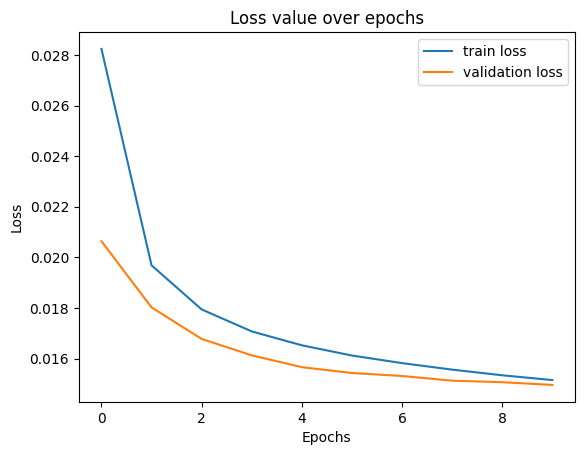

In [ ]:
plot_loss(model_linear_2_loss_history)

In [ ]:
i_train, i_test = inference_on_test(model_linear_2, X_train, X_test)
knn_param_random_search(i_train, y_train, i_test, y_test)

Best Number of Components: {'knn__n_neighbors': 17}
Best Performance: 0.8382999999999999
Accuracy for test set:  0.8318


## Vanilia Auto-encoder with Conv layers and 40 layers at latent space (95% dimensions reduction)

In [ ]:
model_CNN_1_loss_history = train_ae(X_train, model_CNN_1)


Epoch:  1 

train phase


100%|██████████| 540/540 [00:07<00:00, 68.05it/s] 


training_loss:  0.03400891311639161

validation phase


100%|██████████| 60/60 [00:00<00:00, 551.75it/s]


validation_loss:  0.015469493934263785
________________________________________________

Epoch:  2 

train phase


100%|██████████| 540/540 [00:01<00:00, 287.97it/s]


training_loss:  0.013812372990435473

validation phase


100%|██████████| 60/60 [00:00<00:00, 580.88it/s]


validation_loss:  0.012526882719248534
________________________________________________

Epoch:  3 

train phase


100%|██████████| 540/540 [00:01<00:00, 278.99it/s]


training_loss:  0.011994180155711041

validation phase


100%|██████████| 60/60 [00:00<00:00, 644.53it/s]


validation_loss:  0.011429022578522564
________________________________________________

Epoch:  4 

train phase


100%|██████████| 540/540 [00:01<00:00, 289.31it/s]


training_loss:  0.011159846790272881

validation phase


100%|██████████| 60/60 [00:00<00:00, 614.32it/s]


validation_loss:  0.010812314801538984
________________________________________________

Epoch:  5 

train phase


100%|██████████| 540/540 [00:02<00:00, 219.71it/s]


training_loss:  0.010643979865643713

validation phase


100%|██████████| 60/60 [00:00<00:00, 667.18it/s]


validation_loss:  0.010399763969083627
________________________________________________

Epoch:  6 

train phase


100%|██████████| 540/540 [00:01<00:00, 288.83it/s]


training_loss:  0.01027952381754639

validation phase


100%|██████████| 60/60 [00:00<00:00, 641.05it/s]


validation_loss:  0.01006907457485795
________________________________________________

Epoch:  7 

train phase


100%|██████████| 540/540 [00:01<00:00, 290.81it/s]


training_loss:  0.010005375877436664

validation phase


100%|██████████| 60/60 [00:00<00:00, 621.54it/s]


validation_loss:  0.009820401761680841
________________________________________________

Epoch:  8 

train phase


100%|██████████| 540/540 [00:01<00:00, 290.37it/s]


training_loss:  0.009792581914613645

validation phase


100%|██████████| 60/60 [00:00<00:00, 624.54it/s]


validation_loss:  0.009622249783327182
________________________________________________

Epoch:  9 

train phase


100%|██████████| 540/540 [00:01<00:00, 286.57it/s]


training_loss:  0.009622957195258804

validation phase


100%|██████████| 60/60 [00:00<00:00, 644.11it/s]


validation_loss:  0.009467601232851544
________________________________________________

Epoch:  10 

train phase


100%|██████████| 540/540 [00:01<00:00, 287.06it/s]


training_loss:  0.00948044060367263

validation phase


100%|██████████| 60/60 [00:00<00:00, 422.30it/s]


validation_loss:  0.009338688012212515
________________________________________________


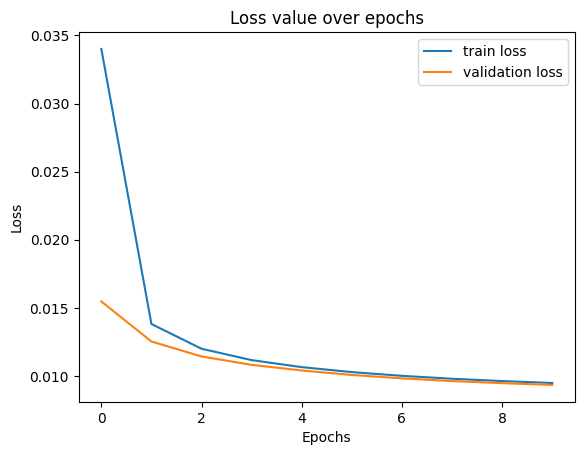

In [ ]:
plot_loss(model_CNN_1_loss_history)

In [ ]:
i_train, i_test = inference_on_test(model_CNN_1, X_train, X_test)
knn_param_random_search(i_train, y_train, i_test, y_test)

Best Number of Components: {'knn__n_neighbors': 9}
Best Performance: 0.8673
Accuracy for test set:  0.8681


## Vanilia Auto-encoder with Conv layers and 7 layers at latent space (99% dimensions reduction)

In [ ]:
model_CNN_2_loss_history = train_ae(X_train, model_CNN_2)


Epoch:  1 

train phase


100%|██████████| 540/540 [00:01<00:00, 288.50it/s]


training_loss:  0.04511474950101089

validation phase


100%|██████████| 60/60 [00:00<00:00, 618.68it/s]


validation_loss:  0.025690006216367085
________________________________________________

Epoch:  2 

train phase


100%|██████████| 540/540 [00:02<00:00, 244.13it/s]


training_loss:  0.024025129768307563

validation phase


100%|██████████| 60/60 [00:00<00:00, 503.06it/s]


validation_loss:  0.022729460864017406
________________________________________________

Epoch:  3 

train phase


100%|██████████| 540/540 [00:02<00:00, 262.35it/s]


training_loss:  0.022155949911447585

validation phase


100%|██████████| 60/60 [00:00<00:00, 634.38it/s]


validation_loss:  0.021494333383937678
________________________________________________

Epoch:  4 

train phase


100%|██████████| 540/540 [00:01<00:00, 286.03it/s]


training_loss:  0.02126789725282126

validation phase


100%|██████████| 60/60 [00:00<00:00, 582.03it/s]


validation_loss:  0.02081656754016876
________________________________________________

Epoch:  5 

train phase


100%|██████████| 540/540 [00:01<00:00, 283.87it/s]


training_loss:  0.020710336623920335

validation phase


100%|██████████| 60/60 [00:00<00:00, 665.62it/s]


validation_loss:  0.020382307066271702
________________________________________________

Epoch:  6 

train phase


100%|██████████| 540/540 [00:01<00:00, 283.46it/s]


training_loss:  0.020313449045298276

validation phase


100%|██████████| 60/60 [00:00<00:00, 640.79it/s]


validation_loss:  0.02002872508019209
________________________________________________

Epoch:  7 

train phase


100%|██████████| 540/540 [00:01<00:00, 282.60it/s]


training_loss:  0.020009128504467233

validation phase


100%|██████████| 60/60 [00:00<00:00, 669.34it/s]


validation_loss:  0.019757924415171147
________________________________________________

Epoch:  8 

train phase


100%|██████████| 540/540 [00:02<00:00, 229.06it/s]


training_loss:  0.019775399851992174

validation phase


100%|██████████| 60/60 [00:00<00:00, 465.52it/s]


validation_loss:  0.019569472844401994
________________________________________________

Epoch:  9 

train phase


100%|██████████| 540/540 [00:01<00:00, 278.47it/s]


training_loss:  0.0195832636034875

validation phase


100%|██████████| 60/60 [00:00<00:00, 623.85it/s]


validation_loss:  0.01939802666505178
________________________________________________

Epoch:  10 

train phase


100%|██████████| 540/540 [00:01<00:00, 285.98it/s]


training_loss:  0.019425831793772955

validation phase


100%|██████████| 60/60 [00:00<00:00, 661.24it/s]

validation_loss:  0.019262577500194313
________________________________________________


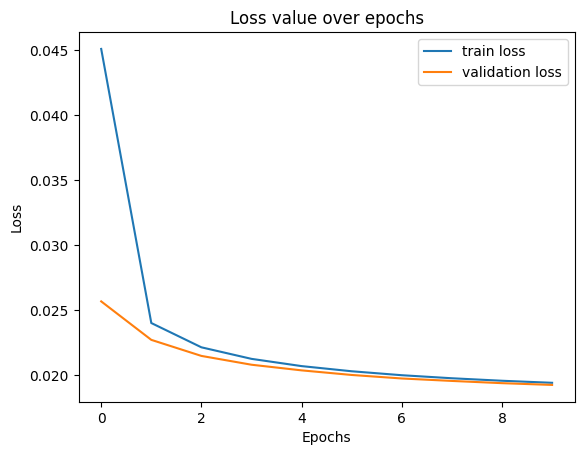

In [ ]:
plot_loss(model_CNN_2_loss_history)

In [ ]:
i_train, i_test = inference_on_test(model_CNN_2, X_train, X_test)
knn_param_random_search(i_train, y_train, i_test, y_test)

Best Number of Components: {'knn__n_neighbors': 25}
Best Performance: 0.8113666666666667
Accuracy for test set:  0.8119


# Variational autoencoder (VAE)

In [ ]:
#from torch import nn
class LinearVAE(nn.Module):
  def __init__(self, latent_space):
    super(LinearVAE, self).__init__()
    primary_space = 784
    self.encoder = torch.nn.Sequential(
      torch.nn.Linear(primary_space, primary_space//2),
      torch.nn.BatchNorm1d(primary_space//2),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//2, primary_space//4),
      torch.nn.BatchNorm1d(primary_space//4),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//4, primary_space//8),
      torch.nn.BatchNorm1d(primary_space//8),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//8, primary_space//16),
      torch.nn.BatchNorm1d(primary_space//16),
      torch.nn.ReLU(True),
      #torch.nn.Linear(primary_space//16, latent_space)
    )
    self.mu = nn.Linear(primary_space//16, latent_space)
    self.logvar = nn.Linear(primary_space//16, latent_space)
    self.decoder = torch.nn.Sequential(
      torch.nn.Linear(latent_space, primary_space//16),
      torch.nn.BatchNorm1d(primary_space//16),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//16, primary_space//8),
      torch.nn.BatchNorm1d(primary_space//8),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//8, primary_space//4),
      torch.nn.BatchNorm1d(primary_space//4),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//4, primary_space//2),
      torch.nn.BatchNorm1d(primary_space//2),
      torch.nn.ReLU(True),
      torch.nn.Linear(primary_space//2, primary_space),
      torch.nn.Sigmoid()
    )
    self.initialize_weights()

  def initialize_weights(self):
    for module in self.encoder.modules():
      if isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
    torch.nn.init.xavier_uniform_(self.mu.weight)
    torch.nn.init.xavier_uniform_(self.logvar.weight)
    for module in self.decoder.modules():
      if isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)

  def encode(self, x):
    e = self.encoder(x)
    mu = self.mu(e)
    logvar = self.logvar(e)
    return mu, logvar, e

  def decode(self, z):
    x = self.decoder(z)
    return x

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std
    return z
  def forward(self, x, disable_decoder = False):
    x = x.reshape((x.shape[0], 28*28))
    mu, logvar, e = self.encode(x)
    z = self.reparameterize(mu, logvar)
    if disable_decoder:
      return z, mu, logvar
    new_x = self.decode(z)
    return new_x, mu, logvar




class CnnVAE(nn.Module):
  def __init__(self, latent_space):
    super(CnnVAE, self).__init__()
    primary_space = 784
    self.encoder = torch.nn.Sequential(
      torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(16),
      torch.nn.ReLU(True),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
      torch.nn.BatchNorm2d(8),
      torch.nn.ReLU(True),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Flatten()
    )


    self.mu = nn.Linear(7*7*8, latent_space)
    self.logvar = nn.Linear(7*7*8, latent_space)
    self.to_decoder = torch.nn.Linear(latent_space, 7*7*8)
    self.decoder = torch.nn.Sequential(
      torch.nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.BatchNorm2d(16),
      torch.nn.ReLU(True),
      torch.nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
      #torch.nn.BatchNorm2d(1)
      torch.nn.Sigmoid()
    )
    self.initialize_weights()

  def initialize_weights(self):
    for module in self.encoder.modules():
      if isinstance(module, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(module.weight)
    torch.nn.init.xavier_uniform_(self.mu.weight)
    torch.nn.init.xavier_uniform_(self.logvar.weight)
    torch.nn.init.xavier_uniform_(self.to_decoder.weight)
    for module in self.decoder.modules():
      if isinstance(module, torch.nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform_(module.weight)

  def encode(self, x):
    e = self.encoder(x)
    mu = self.mu(e)
    logvar = self.logvar(e)
    return mu, logvar, e

  def decode(self, z):
    x = self.decoder(z)
    return x

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std
    return z
  def forward(self, x, disable_decoder = False):
    #x = x.reshape((x.shape[0], 28*28))
    mu, logvar, e = self.encode(x)
    z = self.reparameterize(mu, logvar)
    if disable_decoder:
      return z, mu, logvar
    z = self.to_decoder(z)
    z = z.reshape((x.shape[0],8,7,7))
    new_x = self.decode(z)
    return new_x, mu, logvar


model_linear_1 = LinearVAE(latent_space=40).to(device) #5%
model_linear_2 = LinearVAE(latent_space=7).to(device) #1%
model_CNN_1 = CnnVAE(latent_space=40).to(device)
model_CNN_2 = CnnVAE(latent_space=7).to(device)

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.BCELoss(reduction='sum')(recon_x.reshape((recon_x.shape[0], 28*28)), x.reshape((x.shape[0], 28*28)))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

def train_vae(X_train, model, epochs = 10, batch_size = 100, latent_dim = 40):
  latent_dim = 40
  train_validation_split_index = int(len(X_train) * 0.9)
  X_loader = DataLoader(X_train[:train_validation_split_index], batch_size= batch_size)
  X_val_loader = DataLoader(X_train[train_validation_split_index:], batch_size= batch_size)

  optimizer = torch.optim.AdamW(model.parameters())

  training_loss_history = []
  validation_loss_history = []
  for e in range(epochs):
    print('\nEpoch: ', e+1,'\n')

    print('train phase')
    model.train()
    training_loss = 0
    for data in tqdm(X_loader):
      data = data.to(device)
      recon_batch, mu, logvar = model(data)
      loss = vae_loss(recon_batch, data, mu, logvar)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      training_loss += loss.item()
    training_loss /= len(X_loader)
    print('training_loss: ', training_loss)
    training_loss_history.append(training_loss)

    print('\nvalidation phase')
    model.eval()
    validation_loss = 0
    for data in tqdm(X_val_loader):
      data = data.to(device)
      recon_batch, mu, logvar = model(data)
      #loss = vae_loss(recon_batch, data, mu, logvar)
      loss = vae_loss(recon_batch, data, mu, logvar)
      validation_loss += loss.item()
    validation_loss /= len(X_val_loader)
    print('validation_loss: ', validation_loss)
    validation_loss_history.append(validation_loss)

    print('________________________________________________')
  return training_loss_history, validation_loss_history


def inference_on_test(model, train_set, test_set):
  model.eval()
  with torch.no_grad():
    test_ouput = (model(test_set.to(device), True))[0].cpu()
    train_output = (model(train_set.to(device), True))[0].cpu()
  return train_output, test_ouput


def plot_loss(loss):
  x = range(len(loss[0]))
  plt.plot(x, loss[0], label='train loss')
  plt.plot(x, loss[1], label='validation loss')
  plt.legend()
  #plt.gca().set_yticklabels([])
  plt.title('Loss value over epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

## VAE with Linear layers and 40 layer at latent space (95% dimensions reduction)

In [ ]:
model_linear_1_loss_history = train_vae(X_train, model_linear_1)


Epoch:  1 

train phase


100%|██████████| 540/540 [00:03<00:00, 147.28it/s]


training_loss:  28860.469874855324

validation phase


100%|██████████| 60/60 [00:00<00:00, 374.23it/s]


validation_loss:  26984.731575520833
________________________________________________

Epoch:  2 

train phase


100%|██████████| 540/540 [00:03<00:00, 178.16it/s]


training_loss:  26549.08117404514

validation phase


100%|██████████| 60/60 [00:00<00:00, 378.72it/s]


validation_loss:  26112.7076171875
________________________________________________

Epoch:  3 

train phase


100%|██████████| 540/540 [00:02<00:00, 182.21it/s]


training_loss:  25732.126258680557

validation phase


100%|██████████| 60/60 [00:00<00:00, 388.13it/s]


validation_loss:  25414.401627604166
________________________________________________

Epoch:  4 

train phase


100%|██████████| 540/540 [00:02<00:00, 182.50it/s]


training_loss:  25188.371748408565

validation phase


100%|██████████| 60/60 [00:00<00:00, 388.35it/s]


validation_loss:  24980.235091145834
________________________________________________

Epoch:  5 

train phase


100%|██████████| 540/540 [00:03<00:00, 149.13it/s]


training_loss:  24872.177267795138

validation phase


100%|██████████| 60/60 [00:00<00:00, 386.09it/s]


validation_loss:  24801.101497395834
________________________________________________

Epoch:  6 

train phase


100%|██████████| 540/540 [00:03<00:00, 177.46it/s]


training_loss:  24692.109013310186

validation phase


100%|██████████| 60/60 [00:00<00:00, 381.15it/s]


validation_loss:  24575.742610677084
________________________________________________

Epoch:  7 

train phase


100%|██████████| 540/540 [00:03<00:00, 179.34it/s]


training_loss:  24574.813635706018

validation phase


100%|██████████| 60/60 [00:00<00:00, 366.12it/s]


validation_loss:  24551.815364583334
________________________________________________

Epoch:  8 

train phase


100%|██████████| 540/540 [00:03<00:00, 166.33it/s]


training_loss:  24487.989322916666

validation phase


100%|██████████| 60/60 [00:00<00:00, 273.73it/s]


validation_loss:  24496.63837890625
________________________________________________

Epoch:  9 

train phase


100%|██████████| 540/540 [00:03<00:00, 140.06it/s]


training_loss:  24420.04521484375

validation phase


100%|██████████| 60/60 [00:00<00:00, 190.47it/s]


validation_loss:  24421.923470052083
________________________________________________

Epoch:  10 

train phase


100%|██████████| 540/540 [00:03<00:00, 151.42it/s]


training_loss:  24365.40853949653

validation phase


100%|██████████| 60/60 [00:00<00:00, 351.81it/s]

validation_loss:  24377.538606770835
________________________________________________


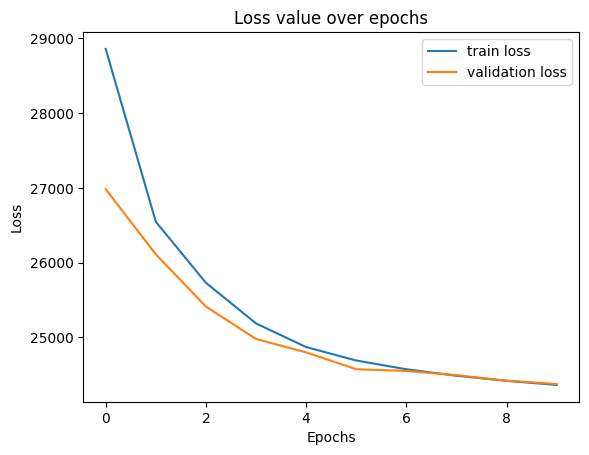

In [ ]:
plot_loss(model_linear_1_loss_history)

In [ ]:
i_train, i_test = inference_on_test(model_linear_1, X_train, X_test)
knn_param_random_search(i_train, y_train, i_test, y_test)

Best Number of Components: {'knn__n_neighbors': 233}
Best Performance: 0.13246666666666668
Accuracy for test set:  0.1285


### EXTRA_MODEL_1: train above model with 50 epochs

In [ ]:
extra_linear_model_1 = LinearVAE(latent_space=40).to(device)
extra_linear_model_1_loss_history = train_vae(X_train, extra_linear_model_1, epochs= 50)


Epoch:  1 

train phase


100%|██████████| 540/540 [00:06<00:00, 85.05it/s] 


training_loss:  28805.78091362847

validation phase


100%|██████████| 60/60 [00:00<00:00, 454.30it/s]


validation_loss:  26979.664680989583
________________________________________________

Epoch:  2 

train phase


100%|██████████| 540/540 [00:03<00:00, 178.73it/s]


training_loss:  26554.366471354166

validation phase


100%|██████████| 60/60 [00:00<00:00, 339.84it/s]


validation_loss:  26135.261360677083
________________________________________________

Epoch:  3 

train phase


100%|██████████| 540/540 [00:02<00:00, 185.81it/s]


training_loss:  25845.45720847801

validation phase


100%|██████████| 60/60 [00:00<00:00, 444.42it/s]


validation_loss:  25517.478450520834
________________________________________________

Epoch:  4 

train phase


100%|██████████| 540/540 [00:02<00:00, 201.11it/s]


training_loss:  25313.09028862847

validation phase


100%|██████████| 60/60 [00:00<00:00, 440.06it/s]


validation_loss:  25062.787923177082
________________________________________________

Epoch:  5 

train phase


100%|██████████| 540/540 [00:02<00:00, 201.77it/s]


training_loss:  24976.40408347801

validation phase


100%|██████████| 60/60 [00:00<00:00, 412.81it/s]


validation_loss:  24825.132161458332
________________________________________________

Epoch:  6 

train phase


100%|██████████| 540/540 [00:02<00:00, 185.54it/s]


training_loss:  24778.873893229167

validation phase


100%|██████████| 60/60 [00:00<00:00, 324.13it/s]


validation_loss:  24678.733723958332
________________________________________________

Epoch:  7 

train phase


100%|██████████| 540/540 [00:02<00:00, 180.28it/s]


training_loss:  24650.229032841435

validation phase


100%|██████████| 60/60 [00:00<00:00, 424.26it/s]


validation_loss:  24556.23837890625
________________________________________________

Epoch:  8 

train phase


100%|██████████| 540/540 [00:02<00:00, 203.76it/s]


training_loss:  24548.542060908563

validation phase


100%|██████████| 60/60 [00:00<00:00, 444.59it/s]


validation_loss:  24504.336783854167
________________________________________________

Epoch:  9 

train phase


100%|██████████| 540/540 [00:02<00:00, 201.47it/s]


training_loss:  24467.173256655093

validation phase


100%|██████████| 60/60 [00:00<00:00, 422.48it/s]


validation_loss:  24410.01484375
________________________________________________

Epoch:  10 

train phase


100%|██████████| 540/540 [00:02<00:00, 180.09it/s]


training_loss:  24412.787434895832

validation phase


100%|██████████| 60/60 [00:00<00:00, 329.61it/s]


validation_loss:  24356.00185546875
________________________________________________

Epoch:  11 

train phase


100%|██████████| 540/540 [00:03<00:00, 177.63it/s]


training_loss:  24361.424189814814

validation phase


100%|██████████| 60/60 [00:00<00:00, 432.04it/s]


validation_loss:  24348.702962239582
________________________________________________

Epoch:  12 

train phase


100%|██████████| 540/540 [00:02<00:00, 200.56it/s]


training_loss:  24312.118424479166

validation phase


100%|██████████| 60/60 [00:00<00:00, 440.70it/s]


validation_loss:  24346.2595703125
________________________________________________

Epoch:  13 

train phase


100%|██████████| 540/540 [00:02<00:00, 201.58it/s]


training_loss:  24282.720149739584

validation phase


100%|██████████| 60/60 [00:00<00:00, 453.13it/s]


validation_loss:  24281.933984375
________________________________________________

Epoch:  14 

train phase


100%|██████████| 540/540 [00:02<00:00, 190.23it/s]


training_loss:  24240.59076244213

validation phase


100%|██████████| 60/60 [00:00<00:00, 336.20it/s]


validation_loss:  24254.86357421875
________________________________________________

Epoch:  15 

train phase


100%|██████████| 540/540 [00:03<00:00, 174.59it/s]


training_loss:  24215.076783130786

validation phase


100%|██████████| 60/60 [00:00<00:00, 448.71it/s]


validation_loss:  24255.367317708333
________________________________________________

Epoch:  16 

train phase


100%|██████████| 540/540 [00:02<00:00, 201.68it/s]


training_loss:  24183.94947554977

validation phase


100%|██████████| 60/60 [00:00<00:00, 452.18it/s]


validation_loss:  24230.5794921875
________________________________________________

Epoch:  17 

train phase


100%|██████████| 540/540 [00:02<00:00, 199.81it/s]


training_loss:  24158.75045211227

validation phase


100%|██████████| 60/60 [00:00<00:00, 436.69it/s]


validation_loss:  24212.3388671875
________________________________________________

Epoch:  18 

train phase


100%|██████████| 540/540 [00:02<00:00, 184.32it/s]


training_loss:  24158.68449074074

validation phase


100%|██████████| 60/60 [00:00<00:00, 307.03it/s]


validation_loss:  24174.196940104168
________________________________________________

Epoch:  19 

train phase


100%|██████████| 540/540 [00:03<00:00, 169.52it/s]


training_loss:  24117.383177806714

validation phase


100%|██████████| 60/60 [00:00<00:00, 456.33it/s]


validation_loss:  24155.3916015625
________________________________________________

Epoch:  20 

train phase


100%|██████████| 540/540 [00:02<00:00, 195.86it/s]


training_loss:  24102.52421875

validation phase


100%|██████████| 60/60 [00:00<00:00, 460.45it/s]


validation_loss:  24137.956901041667
________________________________________________

Epoch:  21 

train phase


100%|██████████| 540/540 [00:02<00:00, 202.12it/s]


training_loss:  24082.134881365742

validation phase


100%|██████████| 60/60 [00:00<00:00, 445.80it/s]


validation_loss:  24142.88271484375
________________________________________________

Epoch:  22 

train phase


100%|██████████| 540/540 [00:02<00:00, 196.85it/s]


training_loss:  24067.25736400463

validation phase


100%|██████████| 60/60 [00:00<00:00, 321.84it/s]


validation_loss:  24174.269661458333
________________________________________________

Epoch:  23 

train phase


100%|██████████| 540/540 [00:03<00:00, 167.64it/s]


training_loss:  24048.204387297454

validation phase


100%|██████████| 60/60 [00:00<00:00, 424.03it/s]


validation_loss:  24121.7740234375
________________________________________________

Epoch:  24 

train phase


100%|██████████| 540/540 [00:02<00:00, 201.37it/s]


training_loss:  24035.91597583912

validation phase


100%|██████████| 60/60 [00:00<00:00, 444.35it/s]


validation_loss:  24102.3162109375
________________________________________________

Epoch:  25 

train phase


100%|██████████| 540/540 [00:02<00:00, 199.61it/s]


training_loss:  24022.278508391202

validation phase


100%|██████████| 60/60 [00:00<00:00, 423.85it/s]


validation_loss:  24137.032584635417
________________________________________________

Epoch:  26 

train phase


100%|██████████| 540/540 [00:02<00:00, 198.40it/s]


training_loss:  24011.520406539352

validation phase


100%|██████████| 60/60 [00:00<00:00, 321.13it/s]


validation_loss:  24082.006966145833
________________________________________________

Epoch:  27 

train phase


100%|██████████| 540/540 [00:03<00:00, 163.92it/s]


training_loss:  23995.001938657406

validation phase


100%|██████████| 60/60 [00:00<00:00, 451.96it/s]


validation_loss:  24122.369466145832
________________________________________________

Epoch:  28 

train phase


100%|██████████| 540/540 [00:02<00:00, 196.60it/s]


training_loss:  23987.21015625

validation phase


100%|██████████| 60/60 [00:00<00:00, 385.26it/s]


validation_loss:  24109.42529296875
________________________________________________

Epoch:  29 

train phase


100%|██████████| 540/540 [00:02<00:00, 197.81it/s]


training_loss:  23973.442328559027

validation phase


100%|██████████| 60/60 [00:00<00:00, 420.23it/s]


validation_loss:  24050.81953125
________________________________________________

Epoch:  30 

train phase


100%|██████████| 540/540 [00:02<00:00, 198.76it/s]


training_loss:  23963.31396484375

validation phase


100%|██████████| 60/60 [00:00<00:00, 300.99it/s]


validation_loss:  24066.526009114583
________________________________________________

Epoch:  31 

train phase


100%|██████████| 540/540 [00:04<00:00, 110.45it/s]


training_loss:  23950.512688078703

validation phase


100%|██████████| 60/60 [00:00<00:00, 436.52it/s]


validation_loss:  24030.087630208334
________________________________________________

Epoch:  32 

train phase


100%|██████████| 540/540 [00:02<00:00, 201.92it/s]


training_loss:  23940.783662471065

validation phase


100%|██████████| 60/60 [00:00<00:00, 435.13it/s]


validation_loss:  24034.79736328125
________________________________________________

Epoch:  33 

train phase


100%|██████████| 540/540 [00:02<00:00, 202.25it/s]


training_loss:  23931.270927372687

validation phase


100%|██████████| 60/60 [00:00<00:00, 452.39it/s]


validation_loss:  24041.732845052084
________________________________________________

Epoch:  34 

train phase


100%|██████████| 540/540 [00:03<00:00, 143.44it/s]


training_loss:  23921.2043004919

validation phase


100%|██████████| 60/60 [00:00<00:00, 425.71it/s]


validation_loss:  24051.773404947915
________________________________________________

Epoch:  35 

train phase


100%|██████████| 540/540 [00:02<00:00, 201.33it/s]


training_loss:  23912.31750217014

validation phase


100%|██████████| 60/60 [00:00<00:00, 445.64it/s]


validation_loss:  24036.83037109375
________________________________________________

Epoch:  36 

train phase


100%|██████████| 540/540 [00:02<00:00, 200.78it/s]


training_loss:  23904.732197627316

validation phase


100%|██████████| 60/60 [00:00<00:00, 447.38it/s]


validation_loss:  24041.6099609375
________________________________________________

Epoch:  37 

train phase


100%|██████████| 540/540 [00:02<00:00, 201.74it/s]


training_loss:  23898.938530815973

validation phase


100%|██████████| 60/60 [00:00<00:00, 440.28it/s]


validation_loss:  24039.640462239582
________________________________________________

Epoch:  38 

train phase


100%|██████████| 540/540 [00:03<00:00, 154.42it/s]


training_loss:  23890.383980758103

validation phase


100%|██████████| 60/60 [00:00<00:00, 430.86it/s]


validation_loss:  23982.572005208334
________________________________________________

Epoch:  39 

train phase


100%|██████████| 540/540 [00:02<00:00, 200.04it/s]


training_loss:  23881.9025426794

validation phase


100%|██████████| 60/60 [00:00<00:00, 457.60it/s]


validation_loss:  24022.712532552083
________________________________________________

Epoch:  40 

train phase


100%|██████████| 540/540 [00:02<00:00, 199.71it/s]


training_loss:  23876.40806568287

validation phase


100%|██████████| 60/60 [00:00<00:00, 450.93it/s]


validation_loss:  23989.893033854165
________________________________________________

Epoch:  41 

train phase


100%|██████████| 540/540 [00:02<00:00, 202.31it/s]


training_loss:  23862.81974464699

validation phase


100%|██████████| 60/60 [00:00<00:00, 452.63it/s]


validation_loss:  23992.06904296875
________________________________________________

Epoch:  42 

train phase


100%|██████████| 540/540 [00:03<00:00, 161.48it/s]


training_loss:  23861.937160011574

validation phase


100%|██████████| 60/60 [00:00<00:00, 442.09it/s]


validation_loss:  24029.554036458332
________________________________________________

Epoch:  43 

train phase


100%|██████████| 540/540 [00:02<00:00, 202.65it/s]


training_loss:  23852.27907986111

validation phase


100%|██████████| 60/60 [00:00<00:00, 431.83it/s]


validation_loss:  24061.3650390625
________________________________________________

Epoch:  44 

train phase


100%|██████████| 540/540 [00:02<00:00, 202.03it/s]


training_loss:  23849.112355324072

validation phase


100%|██████████| 60/60 [00:00<00:00, 459.66it/s]


validation_loss:  24006.221842447918
________________________________________________

Epoch:  45 

train phase


100%|██████████| 540/540 [00:02<00:00, 199.21it/s]


training_loss:  23838.02584273727

validation phase


100%|██████████| 60/60 [00:00<00:00, 420.87it/s]


validation_loss:  23964.491178385415
________________________________________________

Epoch:  46 

train phase


100%|██████████| 540/540 [00:03<00:00, 161.33it/s]


training_loss:  23838.470149739584

validation phase


100%|██████████| 60/60 [00:00<00:00, 345.53it/s]


validation_loss:  23960.58779296875
________________________________________________

Epoch:  47 

train phase


100%|██████████| 540/540 [00:02<00:00, 202.63it/s]


training_loss:  23825.496375868057

validation phase


100%|██████████| 60/60 [00:00<00:00, 456.20it/s]


validation_loss:  23985.905305989585
________________________________________________

Epoch:  48 

train phase


100%|██████████| 540/540 [00:02<00:00, 192.94it/s]


training_loss:  23824.22243923611

validation phase


100%|██████████| 60/60 [00:00<00:00, 436.86it/s]


validation_loss:  23967.107421875
________________________________________________

Epoch:  49 

train phase


100%|██████████| 540/540 [00:02<00:00, 199.92it/s]


training_loss:  23815.924797453703

validation phase


100%|██████████| 60/60 [00:00<00:00, 449.33it/s]


validation_loss:  23989.996126302085
________________________________________________

Epoch:  50 

train phase


100%|██████████| 540/540 [00:03<00:00, 164.09it/s]


training_loss:  23811.1484375

validation phase


100%|██████████| 60/60 [00:00<00:00, 306.44it/s]

validation_loss:  24012.835807291667
________________________________________________


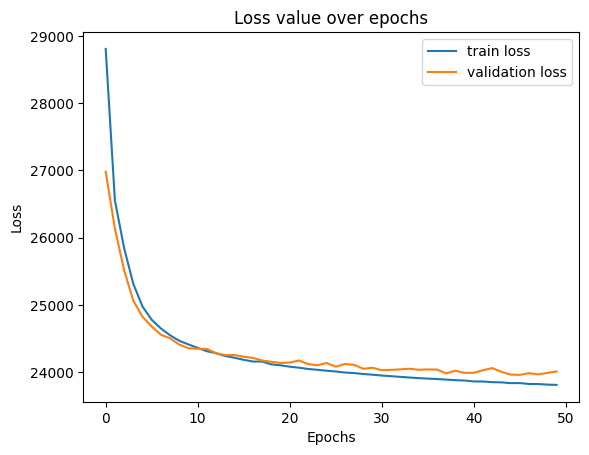

In [ ]:
plot_loss(extra_linear_model_1_loss_history)

In [ ]:
i_train, i_test = inference_on_test(extra_linear_model_1, X_train, X_test)
knn_param_random_search(i_train, y_train, i_test, y_test)

Best Number of Components: {'knn__n_neighbors': 188}
Best Performance: 0.6825166666666667
Accuracy for test set:  0.6823


## VAE with Linear layers and 7 layer at latent space (99% dimensions reduction)

In [ ]:
model_linear_2_loss_history = train_vae(X_train, model_linear_2)


Epoch:  1 

train phase


100%|██████████| 540/540 [00:06<00:00, 78.96it/s] 


training_loss:  27439.20620659722

validation phase


100%|██████████| 60/60 [00:00<00:00, 190.21it/s]


validation_loss:  25646.825748697916
________________________________________________

Epoch:  2 

train phase


100%|██████████| 540/540 [00:03<00:00, 147.81it/s]


training_loss:  25331.82295283565

validation phase


100%|██████████| 60/60 [00:00<00:00, 383.06it/s]


validation_loss:  25067.406608072917
________________________________________________

Epoch:  3 

train phase


100%|██████████| 540/540 [00:02<00:00, 185.48it/s]


training_loss:  24959.34351490162

validation phase


100%|██████████| 60/60 [00:00<00:00, 373.25it/s]


validation_loss:  24825.208756510416
________________________________________________

Epoch:  4 

train phase


100%|██████████| 540/540 [00:02<00:00, 186.41it/s]


training_loss:  24751.873701533565

validation phase


100%|██████████| 60/60 [00:00<00:00, 373.11it/s]


validation_loss:  24687.436360677082
________________________________________________

Epoch:  5 

train phase


100%|██████████| 540/540 [00:02<00:00, 184.64it/s]


training_loss:  24619.72429108796

validation phase


100%|██████████| 60/60 [00:00<00:00, 369.36it/s]


validation_loss:  24578.816666666666
________________________________________________

Epoch:  6 

train phase


100%|██████████| 540/540 [00:03<00:00, 149.29it/s]


training_loss:  24524.894169560186

validation phase


100%|██████████| 60/60 [00:00<00:00, 387.00it/s]


validation_loss:  24547.88310546875
________________________________________________

Epoch:  7 

train phase


100%|██████████| 540/540 [00:02<00:00, 184.60it/s]


training_loss:  24445.76048900463

validation phase


100%|██████████| 60/60 [00:00<00:00, 375.19it/s]


validation_loss:  24440.8794921875
________________________________________________

Epoch:  8 

train phase


100%|██████████| 540/540 [00:02<00:00, 186.15it/s]


training_loss:  24378.76499927662

validation phase


100%|██████████| 60/60 [00:00<00:00, 404.75it/s]


validation_loss:  24367.045052083333
________________________________________________

Epoch:  9 

train phase


100%|██████████| 540/540 [00:02<00:00, 184.42it/s]


training_loss:  24327.581915509258

validation phase


100%|██████████| 60/60 [00:00<00:00, 285.47it/s]


validation_loss:  24331.557942708332
________________________________________________

Epoch:  10 

train phase


100%|██████████| 540/540 [00:05<00:00, 98.94it/s] 


training_loss:  24279.334537760416

validation phase


100%|██████████| 60/60 [00:00<00:00, 404.12it/s]

validation_loss:  24292.406087239582
________________________________________________


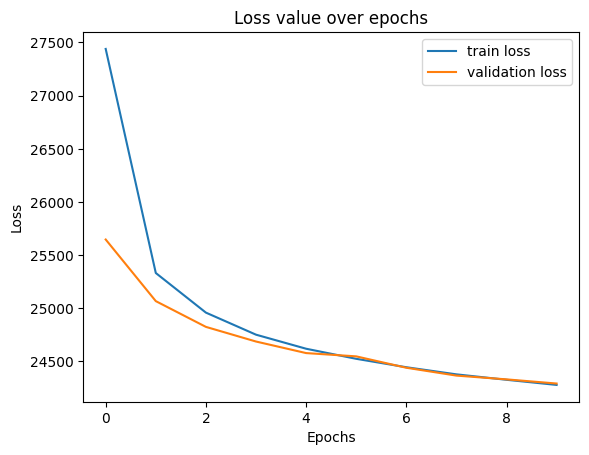

In [ ]:
plot_loss(model_linear_2_loss_history)

In [ ]:
i_train, i_test = inference_on_test(model_linear_2, X_train, X_test)
knn_param_random_search(i_train, y_train, i_test, y_test)

Best Number of Components: {'knn__n_neighbors': 37}
Best Performance: 0.8127833333333333
Accuracy for test set:  0.8049


### EXTRA_MODEL_2: train above model with 50 epochs

In [ ]:
extra_linear_model_2 = LinearVAE(latent_space=7)
extra_linear_model_2_loss_history = train_vae(X_train, extra_linear_model_2.to(device), epochs=50)


Epoch:  1 

train phase


100%|██████████| 540/540 [00:05<00:00, 98.57it/s] 


training_loss:  27494.279694733796

validation phase


100%|██████████| 60/60 [00:00<00:00, 377.08it/s]


validation_loss:  25641.617317708333
________________________________________________

Epoch:  2 

train phase


100%|██████████| 540/540 [00:02<00:00, 186.56it/s]


training_loss:  25366.913306568287

validation phase


100%|██████████| 60/60 [00:00<00:00, 400.97it/s]


validation_loss:  25088.824283854166
________________________________________________

Epoch:  3 

train phase


100%|██████████| 540/540 [00:02<00:00, 182.82it/s]


training_loss:  24967.60197482639

validation phase


100%|██████████| 60/60 [00:00<00:00, 297.77it/s]


validation_loss:  24868.854752604166
________________________________________________

Epoch:  4 

train phase


100%|██████████| 540/540 [00:03<00:00, 152.70it/s]


training_loss:  24749.317332175928

validation phase


100%|██████████| 60/60 [00:00<00:00, 380.41it/s]


validation_loss:  24635.222037760417
________________________________________________

Epoch:  5 

train phase


100%|██████████| 540/540 [00:02<00:00, 184.65it/s]


training_loss:  24606.21390335648

validation phase


100%|██████████| 60/60 [00:00<00:00, 399.03it/s]


validation_loss:  24559.040625
________________________________________________

Epoch:  6 

train phase


100%|██████████| 540/540 [00:02<00:00, 185.10it/s]


training_loss:  24509.956510416665

validation phase


100%|██████████| 60/60 [00:00<00:00, 383.23it/s]


validation_loss:  24458.507845052085
________________________________________________

Epoch:  7 

train phase


100%|██████████| 540/540 [00:03<00:00, 169.13it/s]


training_loss:  24437.22550636574

validation phase


100%|██████████| 60/60 [00:00<00:00, 292.52it/s]


validation_loss:  24435.663899739582
________________________________________________

Epoch:  8 

train phase


100%|██████████| 540/540 [00:03<00:00, 162.18it/s]


training_loss:  24368.915458622687

validation phase


100%|██████████| 60/60 [00:00<00:00, 355.26it/s]


validation_loss:  24312.581184895833
________________________________________________

Epoch:  9 

train phase


100%|██████████| 540/540 [00:02<00:00, 188.01it/s]


training_loss:  24312.564351851852

validation phase


100%|██████████| 60/60 [00:00<00:00, 362.81it/s]


validation_loss:  24298.81103515625
________________________________________________

Epoch:  10 

train phase


100%|██████████| 540/540 [00:02<00:00, 187.87it/s]


training_loss:  24275.31416015625

validation phase


100%|██████████| 60/60 [00:00<00:00, 354.54it/s]


validation_loss:  24309.725716145833
________________________________________________

Epoch:  11 

train phase


100%|██████████| 540/540 [00:03<00:00, 158.36it/s]


training_loss:  24231.681741898148

validation phase


100%|██████████| 60/60 [00:00<00:00, 267.90it/s]


validation_loss:  24249.398014322916
________________________________________________

Epoch:  12 

train phase


100%|██████████| 540/540 [00:03<00:00, 178.20it/s]


training_loss:  24194.25474537037

validation phase


100%|██████████| 60/60 [00:00<00:00, 393.67it/s]


validation_loss:  24222.3384765625
________________________________________________

Epoch:  13 

train phase


100%|██████████| 540/540 [00:02<00:00, 184.80it/s]


training_loss:  24163.175651041667

validation phase


100%|██████████| 60/60 [00:00<00:00, 384.28it/s]


validation_loss:  24192.485319010415
________________________________________________

Epoch:  14 

train phase


100%|██████████| 540/540 [00:02<00:00, 184.06it/s]


training_loss:  24135.492936197916

validation phase


100%|██████████| 60/60 [00:00<00:00, 400.13it/s]


validation_loss:  24145.749381510417
________________________________________________

Epoch:  15 

train phase


100%|██████████| 540/540 [00:03<00:00, 148.89it/s]


training_loss:  24111.457678674768

validation phase


100%|██████████| 60/60 [00:00<00:00, 388.36it/s]


validation_loss:  24174.020149739583
________________________________________________

Epoch:  16 

train phase


100%|██████████| 540/540 [00:02<00:00, 184.88it/s]


training_loss:  24087.316901765047

validation phase


100%|██████████| 60/60 [00:00<00:00, 403.43it/s]


validation_loss:  24127.167610677083
________________________________________________

Epoch:  17 

train phase


100%|██████████| 540/540 [00:02<00:00, 181.09it/s]


training_loss:  24068.75874565972

validation phase


100%|██████████| 60/60 [00:00<00:00, 390.47it/s]


validation_loss:  24136.184016927084
________________________________________________

Epoch:  18 

train phase


100%|██████████| 540/540 [00:02<00:00, 187.24it/s]


training_loss:  24046.00062572338

validation phase


100%|██████████| 60/60 [00:00<00:00, 396.03it/s]


validation_loss:  24147.70595703125
________________________________________________

Epoch:  19 

train phase


100%|██████████| 540/540 [00:03<00:00, 149.51it/s]


training_loss:  24031.040049913194

validation phase


100%|██████████| 60/60 [00:00<00:00, 387.12it/s]


validation_loss:  24115.256575520834
________________________________________________

Epoch:  20 

train phase


100%|██████████| 540/540 [00:02<00:00, 184.08it/s]


training_loss:  24011.419165943287

validation phase


100%|██████████| 60/60 [00:00<00:00, 386.02it/s]


validation_loss:  24097.038444010417
________________________________________________

Epoch:  21 

train phase


100%|██████████| 540/540 [00:02<00:00, 185.20it/s]


training_loss:  23993.087333622687

validation phase


100%|██████████| 60/60 [00:00<00:00, 389.59it/s]


validation_loss:  24076.071321614585
________________________________________________

Epoch:  22 

train phase


100%|██████████| 540/540 [00:03<00:00, 179.25it/s]


training_loss:  23978.674696180555

validation phase


100%|██████████| 60/60 [00:00<00:00, 292.08it/s]


validation_loss:  24050.462109375
________________________________________________

Epoch:  23 

train phase


100%|██████████| 540/540 [00:03<00:00, 157.47it/s]


training_loss:  23962.500690827546

validation phase


100%|██████████| 60/60 [00:00<00:00, 379.75it/s]


validation_loss:  24044.378450520835
________________________________________________

Epoch:  24 

train phase


100%|██████████| 540/540 [00:02<00:00, 186.90it/s]


training_loss:  23949.516456886573

validation phase


100%|██████████| 60/60 [00:00<00:00, 361.71it/s]


validation_loss:  24059.378483072916
________________________________________________

Epoch:  25 

train phase


100%|██████████| 540/540 [00:02<00:00, 187.44it/s]


training_loss:  23933.836823640046

validation phase


100%|██████████| 60/60 [00:00<00:00, 376.20it/s]


validation_loss:  24041.801920572918
________________________________________________

Epoch:  26 

train phase


100%|██████████| 540/540 [00:03<00:00, 164.28it/s]


training_loss:  23924.60841652199

validation phase


100%|██████████| 60/60 [00:00<00:00, 284.07it/s]


validation_loss:  24040.671647135416
________________________________________________

Epoch:  27 

train phase


100%|██████████| 540/540 [00:03<00:00, 167.22it/s]


training_loss:  23914.32781756366

validation phase


100%|██████████| 60/60 [00:00<00:00, 406.83it/s]


validation_loss:  24030.852311197916
________________________________________________

Epoch:  28 

train phase


100%|██████████| 540/540 [00:02<00:00, 183.55it/s]


training_loss:  23897.737720630786

validation phase


100%|██████████| 60/60 [00:00<00:00, 383.21it/s]


validation_loss:  23999.70732421875
________________________________________________

Epoch:  29 

train phase


100%|██████████| 540/540 [00:02<00:00, 183.92it/s]


training_loss:  23891.329076244212

validation phase


100%|██████████| 60/60 [00:00<00:00, 393.13it/s]


validation_loss:  24004.439388020834
________________________________________________

Epoch:  30 

train phase


100%|██████████| 540/540 [00:03<00:00, 152.17it/s]


training_loss:  23876.831792534722

validation phase


100%|██████████| 60/60 [00:00<00:00, 291.43it/s]


validation_loss:  24024.459244791666
________________________________________________

Epoch:  31 

train phase


100%|██████████| 540/540 [00:02<00:00, 182.20it/s]


training_loss:  23870.398524305554

validation phase


100%|██████████| 60/60 [00:00<00:00, 389.77it/s]


validation_loss:  23990.337565104168
________________________________________________

Epoch:  32 

train phase


100%|██████████| 540/540 [00:02<00:00, 186.43it/s]


training_loss:  23859.714243344908

validation phase


100%|██████████| 60/60 [00:00<00:00, 388.86it/s]


validation_loss:  24011.53203125
________________________________________________

Epoch:  33 

train phase


100%|██████████| 540/540 [00:02<00:00, 183.54it/s]


training_loss:  23851.24375

validation phase


100%|██████████| 60/60 [00:00<00:00, 395.26it/s]


validation_loss:  23990.788639322916
________________________________________________

Epoch:  34 

train phase


100%|██████████| 540/540 [00:03<00:00, 149.84it/s]


training_loss:  23841.808836082175

validation phase


100%|██████████| 60/60 [00:00<00:00, 400.89it/s]


validation_loss:  23974.962141927084
________________________________________________

Epoch:  35 

train phase


100%|██████████| 540/540 [00:02<00:00, 184.13it/s]


training_loss:  23834.36771918403

validation phase


100%|██████████| 60/60 [00:00<00:00, 380.31it/s]


validation_loss:  23972.766861979166
________________________________________________

Epoch:  36 

train phase


100%|██████████| 540/540 [00:02<00:00, 185.11it/s]


training_loss:  23824.832848668982

validation phase


100%|██████████| 60/60 [00:00<00:00, 378.61it/s]


validation_loss:  23953.14482421875
________________________________________________

Epoch:  37 

train phase


100%|██████████| 540/540 [00:02<00:00, 185.14it/s]


training_loss:  23820.286201533563

validation phase


100%|██████████| 60/60 [00:00<00:00, 382.22it/s]


validation_loss:  23972.0517578125
________________________________________________

Epoch:  38 

train phase


100%|██████████| 540/540 [00:03<00:00, 147.69it/s]


training_loss:  23805.290856481482

validation phase


100%|██████████| 60/60 [00:00<00:00, 376.40it/s]


validation_loss:  23981.99345703125
________________________________________________

Epoch:  39 

train phase


100%|██████████| 540/540 [00:02<00:00, 182.27it/s]


training_loss:  23803.19552589699

validation phase


100%|██████████| 60/60 [00:00<00:00, 395.71it/s]


validation_loss:  23950.29140625
________________________________________________

Epoch:  40 

train phase


100%|██████████| 540/540 [00:02<00:00, 184.12it/s]


training_loss:  23794.078077980324

validation phase


100%|██████████| 60/60 [00:00<00:00, 380.29it/s]


validation_loss:  23939.7359375
________________________________________________

Epoch:  41 

train phase


100%|██████████| 540/540 [00:03<00:00, 174.28it/s]


training_loss:  23791.911219618054

validation phase


100%|██████████| 60/60 [00:00<00:00, 288.25it/s]


validation_loss:  23990.33408203125
________________________________________________

Epoch:  42 

train phase


100%|██████████| 540/540 [00:03<00:00, 162.28it/s]


training_loss:  23782.612120225695

validation phase


100%|██████████| 60/60 [00:00<00:00, 400.32it/s]


validation_loss:  23952.533170572915
________________________________________________

Epoch:  43 

train phase


100%|██████████| 540/540 [00:02<00:00, 184.04it/s]


training_loss:  23776.443840422453

validation phase


100%|██████████| 60/60 [00:00<00:00, 351.48it/s]


validation_loss:  23936.661783854168
________________________________________________

Epoch:  44 

train phase


100%|██████████| 540/540 [00:02<00:00, 182.80it/s]


training_loss:  23772.442173032407

validation phase


100%|██████████| 60/60 [00:00<00:00, 373.92it/s]


validation_loss:  23953.135416666668
________________________________________________

Epoch:  45 

train phase


100%|██████████| 540/540 [00:03<00:00, 154.04it/s]


training_loss:  23769.18597728588

validation phase


100%|██████████| 60/60 [00:00<00:00, 275.98it/s]


validation_loss:  23956.6169921875
________________________________________________

Epoch:  46 

train phase


100%|██████████| 540/540 [00:03<00:00, 173.50it/s]


training_loss:  23759.052973090278

validation phase


100%|██████████| 60/60 [00:00<00:00, 381.07it/s]


validation_loss:  23956.733984375
________________________________________________

Epoch:  47 

train phase


100%|██████████| 540/540 [00:02<00:00, 183.34it/s]


training_loss:  23755.27511935764

validation phase


100%|██████████| 60/60 [00:00<00:00, 372.99it/s]


validation_loss:  23923.509733072915
________________________________________________

Epoch:  48 

train phase


100%|██████████| 540/540 [00:02<00:00, 184.08it/s]


training_loss:  23751.39593460648

validation phase


100%|██████████| 60/60 [00:00<00:00, 377.65it/s]


validation_loss:  23923.162337239584
________________________________________________

Epoch:  49 

train phase


100%|██████████| 540/540 [00:03<00:00, 147.86it/s]


training_loss:  23740.030110677082

validation phase


100%|██████████| 60/60 [00:00<00:00, 382.81it/s]


validation_loss:  23915.144205729168
________________________________________________

Epoch:  50 

train phase


100%|██████████| 540/540 [00:02<00:00, 183.65it/s]


training_loss:  23736.796245659723

validation phase


100%|██████████| 60/60 [00:00<00:00, 369.23it/s]

validation_loss:  23926.697005208334
________________________________________________


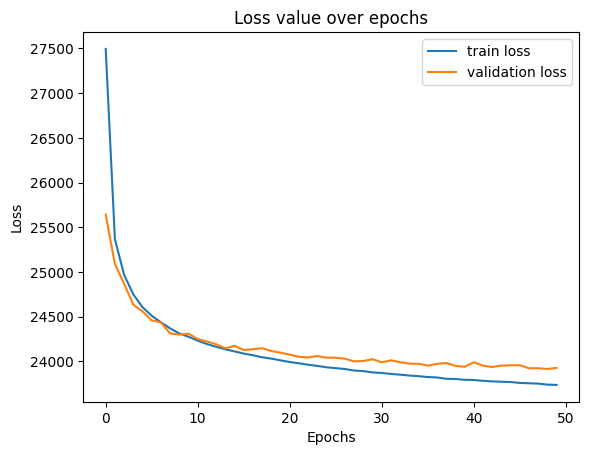

In [ ]:
plot_loss(extra_linear_model_2_loss_history)

In [ ]:
i_train, i_test = inference_on_test(extra_linear_model_2, X_train, X_test)
knn_param_random_search(i_train, y_train, i_test, y_test)

Best Number of Components: {'knn__n_neighbors': 29}
Best Performance: 0.8222833333333334
Accuracy for test set:  0.8198


## VAE with Conv layers and 40 layer at latent space (95% dimensions reduction)

In [ ]:
model_CNN_1_loss_history = train_vae(X_train, model_CNN_1)


Epoch:  1 

train phase


100%|██████████| 540/540 [00:10<00:00, 49.99it/s] 


training_loss:  30425.031474247684

validation phase


100%|██████████| 60/60 [00:00<00:00, 463.11it/s]


validation_loss:  26836.078678385416
________________________________________________

Epoch:  2 

train phase


100%|██████████| 540/540 [00:02<00:00, 186.06it/s]


training_loss:  26154.6474609375

validation phase


100%|██████████| 60/60 [00:00<00:00, 413.04it/s]


validation_loss:  25952.579427083332
________________________________________________

Epoch:  3 

train phase


100%|██████████| 540/540 [00:02<00:00, 229.78it/s]


training_loss:  25642.866666666665

validation phase


100%|██████████| 60/60 [00:00<00:00, 489.62it/s]


validation_loss:  25647.498990885415
________________________________________________

Epoch:  4 

train phase


100%|██████████| 540/540 [00:02<00:00, 233.66it/s]


training_loss:  25425.5875

validation phase


100%|██████████| 60/60 [00:00<00:00, 497.58it/s]


validation_loss:  25468.941145833334
________________________________________________

Epoch:  5 

train phase


100%|██████████| 540/540 [00:02<00:00, 227.41it/s]


training_loss:  25274.75595341435

validation phase


100%|██████████| 60/60 [00:00<00:00, 484.44it/s]


validation_loss:  25361.73935546875
________________________________________________

Epoch:  6 

train phase


100%|██████████| 540/540 [00:02<00:00, 215.89it/s]


training_loss:  25177.4240270544

validation phase


100%|██████████| 60/60 [00:00<00:00, 374.39it/s]


validation_loss:  25278.039583333335
________________________________________________

Epoch:  7 

train phase


100%|██████████| 540/540 [00:02<00:00, 202.60it/s]


training_loss:  25096.62868923611

validation phase


100%|██████████| 60/60 [00:00<00:00, 506.13it/s]


validation_loss:  25180.8994140625
________________________________________________

Epoch:  8 

train phase


100%|██████████| 540/540 [00:02<00:00, 233.05it/s]


training_loss:  25036.367415364584

validation phase


100%|██████████| 60/60 [00:00<00:00, 464.05it/s]


validation_loss:  25136.0474609375
________________________________________________

Epoch:  9 

train phase


100%|██████████| 540/540 [00:02<00:00, 233.37it/s]


training_loss:  24993.66605179398

validation phase


100%|██████████| 60/60 [00:00<00:00, 475.86it/s]


validation_loss:  25104.98076171875
________________________________________________

Epoch:  10 

train phase


100%|██████████| 540/540 [00:02<00:00, 237.18it/s]


training_loss:  24945.75178313079

validation phase


100%|██████████| 60/60 [00:00<00:00, 483.91it/s]

validation_loss:  25071.047591145834
________________________________________________


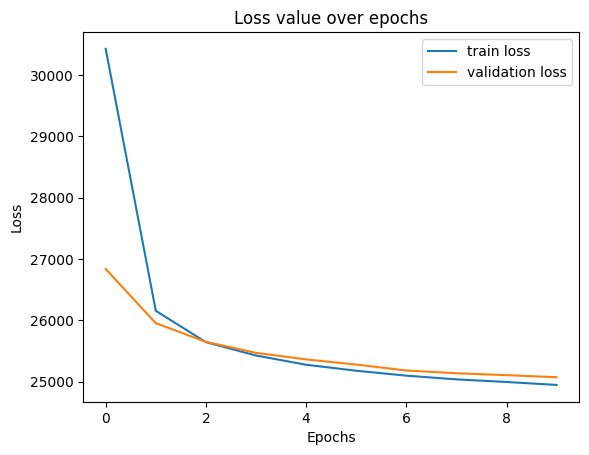

In [ ]:
plot_loss(model_CNN_1_loss_history)

In [ ]:
i_train, i_test = inference_on_test(model_CNN_1, X_train, X_test)
knn_param_random_search(i_train, y_train, i_test, y_test)

Best Number of Components: {'knn__n_neighbors': 58}
Best Performance: 0.7549333333333335
Accuracy for test set:  0.7482


## VAE with Conv layers and 7 layer at latent space (99% dimensions reduction)

In [ ]:
model_CNN_2_loss_history = train_vae(X_train, model_CNN_2.to(device))


Epoch:  1 

train phase


100%|██████████| 540/540 [00:03<00:00, 139.36it/s]


training_loss:  30055.012141927084

validation phase


100%|██████████| 60/60 [00:00<00:00, 316.47it/s]


validation_loss:  26562.696712239584
________________________________________________

Epoch:  2 

train phase


100%|██████████| 540/540 [00:02<00:00, 230.18it/s]


training_loss:  26050.227683738427

validation phase


100%|██████████| 60/60 [00:00<00:00, 473.62it/s]


validation_loss:  25954.056608072915
________________________________________________

Epoch:  3 

train phase


100%|██████████| 540/540 [00:03<00:00, 170.84it/s]


training_loss:  25677.904246238428

validation phase


100%|██████████| 60/60 [00:00<00:00, 204.39it/s]


validation_loss:  25714.64541015625
________________________________________________

Epoch:  4 

train phase


100%|██████████| 540/540 [00:03<00:00, 163.41it/s]


training_loss:  25507.081615306714

validation phase


100%|██████████| 60/60 [00:00<00:00, 485.03it/s]


validation_loss:  25570.884733072915
________________________________________________

Epoch:  5 

train phase


100%|██████████| 540/540 [00:02<00:00, 233.05it/s]


training_loss:  25389.83673683449

validation phase


100%|██████████| 60/60 [00:00<00:00, 489.81it/s]


validation_loss:  25469.180924479166
________________________________________________

Epoch:  6 

train phase


100%|██████████| 540/540 [00:02<00:00, 234.87it/s]


training_loss:  25317.506843171297

validation phase


100%|██████████| 60/60 [00:00<00:00, 468.03it/s]


validation_loss:  25420.482161458334
________________________________________________

Epoch:  7 

train phase


100%|██████████| 540/540 [00:02<00:00, 228.55it/s]


training_loss:  25257.152213541667

validation phase


100%|██████████| 60/60 [00:00<00:00, 337.93it/s]


validation_loss:  25356.561263020834
________________________________________________

Epoch:  8 

train phase


100%|██████████| 540/540 [00:02<00:00, 183.79it/s]


training_loss:  25213.62178096065

validation phase


100%|██████████| 60/60 [00:00<00:00, 468.61it/s]


validation_loss:  25320.473763020833
________________________________________________

Epoch:  9 

train phase


100%|██████████| 540/540 [00:02<00:00, 203.29it/s]


training_loss:  25179.88029152199

validation phase


100%|██████████| 60/60 [00:00<00:00, 245.22it/s]


validation_loss:  25304.634016927084
________________________________________________

Epoch:  10 

train phase


100%|██████████| 540/540 [00:06<00:00, 89.65it/s]


training_loss:  25148.08916015625

validation phase


100%|██████████| 60/60 [00:00<00:00, 249.27it/s]

validation_loss:  25294.49638671875
________________________________________________


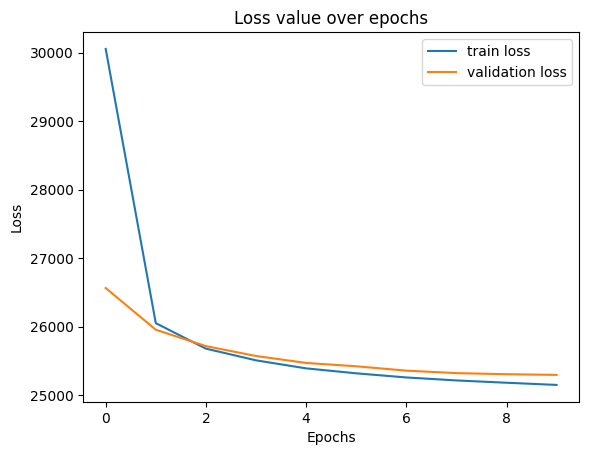

In [ ]:
plot_loss(model_CNN_2_loss_history)

In [ ]:
i_train, i_test = inference_on_test(model_CNN_2, X_train, X_test)
knn_param_random_search(i_train, y_train, i_test, y_test)

Best Number of Components: {'knn__n_neighbors': 29}
Best Performance: 0.7903833333333333
Accuracy for test set:  0.7889


# investigating the latent space

In [ ]:
def plot_latent_space(model = None, n=10, figsize=6, arch = 'linear'):
    image_size = 28
    scale = 2.0
    figure = np.zeros((image_size * n, image_size * n))
    grid_x = torch.linspace(-2, 2, 10) # = grid_x = np.linspace(-scale, scale, n)
    grid_y = torch.flip(torch.linspace(-2, 2, 10),(0,)) # = #grid_y = np.linspace(-scale, scale, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            x_decoded = norms_to_img(model, torch.tensor([xi, yi]), arch).cpu().detach().numpy()
            image = x_decoded[0].reshape(image_size, image_size)
            figure[
                i * image_size : (i + 1) * image_size,
                j * image_size : (j + 1) * image_size,
            ] = image

    plt.figure(figsize=(figsize, figsize))
    start_range = image_size // 2
    end_range = n * image_size + start_range
    pixel_range = np.arange(start_range, end_range, image_size)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

def plot_label_clusters(model, data, labels, param = 'z'):
  data = data.to(device)
  if param == 'z':
    z_mean,_, _ = model(data, True)
  elif param == 'mean':
    _, z_mean, _ = model(data, True)
  else:
    _, _, z_mean = model(data, True)
  z_mean = z_mean.cpu().detach().numpy()
  plt.figure(figsize=(8, 6))
  scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='Spectral', alpha=0.5)
  num_labels = len(np.unique(labels))
  cb = plt.colorbar(scatter)
  fashion_mnist_labels = ['T-shirt/top', 'Trouser', 'Pullover',
                          'Dress', 'Coat', 'Sandal', 'Shirt',
                          'Sneaker', 'Bag', 'Ankle boot']
  cb.set_ticks(np.arange(num_labels))
  cb.set_ticklabels(fashion_mnist_labels)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.show();

def norms_to_img(model, z, arch = 'cnn'):
  z = z.to(device)
  if arch == 'cnn':
    z = model.to_decoder(z)
    z = z.reshape((1,8,7,7))
  else:
    z=z.reshape((1, 2))
  new_x = model.decode(z)
  return new_x

In [ ]:
investigating_model = LinearVAE(2).to(device)
investigating_model_loss = train_vae(X_train, investigating_model)


Epoch:  1 

train phase


100%|██████████| 540/540 [00:06<00:00, 88.95it/s] 


training_loss:  28236.992133246527

validation phase


100%|██████████| 60/60 [00:00<00:00, 294.20it/s]


validation_loss:  26845.5193359375
________________________________________________

Epoch:  2 

train phase


100%|██████████| 540/540 [00:03<00:00, 160.40it/s]


training_loss:  26528.545106336805

validation phase


100%|██████████| 60/60 [00:00<00:00, 403.19it/s]


validation_loss:  26488.51171875
________________________________________________

Epoch:  3 

train phase


100%|██████████| 540/540 [00:02<00:00, 189.76it/s]


training_loss:  26266.412644675926

validation phase


100%|██████████| 60/60 [00:00<00:00, 369.54it/s]


validation_loss:  26269.44287109375
________________________________________________

Epoch:  4 

train phase


100%|██████████| 540/540 [00:04<00:00, 126.82it/s]


training_loss:  26107.23539134838

validation phase


100%|██████████| 60/60 [00:00<00:00, 154.85it/s]


validation_loss:  26105.45126953125
________________________________________________

Epoch:  5 

train phase


100%|██████████| 540/540 [00:03<00:00, 151.64it/s]


training_loss:  26022.25314670139

validation phase


100%|██████████| 60/60 [00:00<00:00, 398.39it/s]


validation_loss:  26029.604947916665
________________________________________________

Epoch:  6 

train phase


100%|██████████| 540/540 [00:02<00:00, 187.01it/s]


training_loss:  25932.369108072915

validation phase


100%|██████████| 60/60 [00:00<00:00, 366.79it/s]


validation_loss:  25950.379427083335
________________________________________________

Epoch:  7 

train phase


100%|██████████| 540/540 [00:02<00:00, 187.26it/s]


training_loss:  25874.834262876157

validation phase


100%|██████████| 60/60 [00:00<00:00, 401.50it/s]


validation_loss:  25953.384440104168
________________________________________________

Epoch:  8 

train phase


100%|██████████| 540/540 [00:02<00:00, 189.60it/s]


training_loss:  25818.033799913195

validation phase


100%|██████████| 60/60 [00:00<00:00, 339.48it/s]


validation_loss:  25909.5150390625
________________________________________________

Epoch:  9 

train phase


100%|██████████| 540/540 [00:03<00:00, 153.68it/s]


training_loss:  25760.13798828125

validation phase


100%|██████████| 60/60 [00:00<00:00, 406.86it/s]


validation_loss:  25937.26953125
________________________________________________

Epoch:  10 

train phase


100%|██████████| 540/540 [00:02<00:00, 189.61it/s]


training_loss:  25725.326634837962

validation phase


100%|██████████| 60/60 [00:00<00:00, 364.81it/s]

validation_loss:  25839.410579427084
________________________________________________


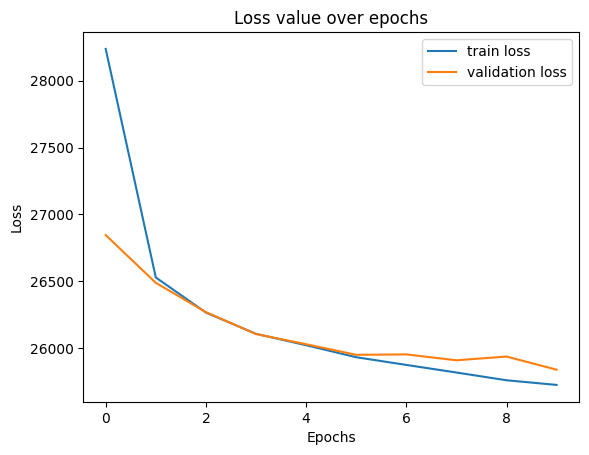

In [ ]:
plot_loss(investigating_model_loss)

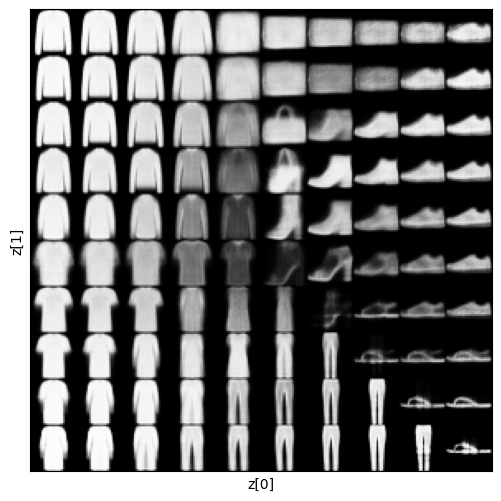

In [ ]:
plot_latent_space(investigating_model)

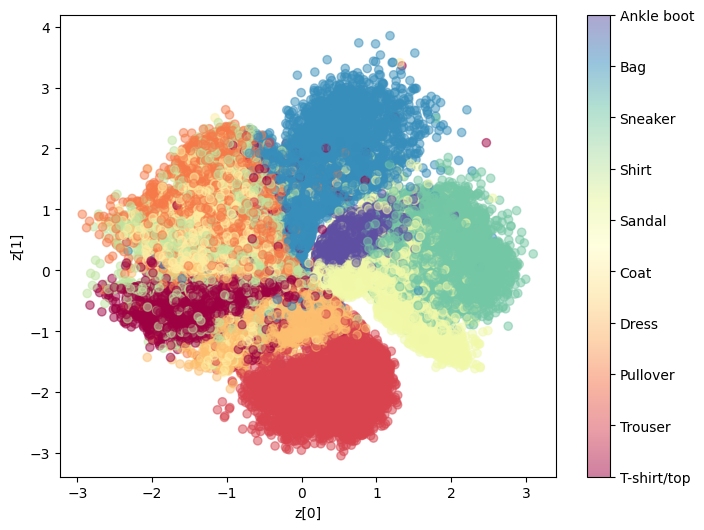

In [ ]:
plot_label_clusters(investigating_model, X_train ,y_train)